# Binary Sentiment Analysis of Movie Reviews

In [32]:
import string
from itertools import chain
from time import time
import pandas as pd
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.corpus import movie_reviews as mr
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer

# scikit learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

# keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

### Data preparation
Read corpus and create a list of dictionaries (**data**), each corresponding to a movie review and its sentiment.

In [2]:
data = [] # list of dictionaries with keys 'text' and 'sentiment'

# create a useful dictionary from each review
for category in mr.categories():
    for fileid in mr.fileids(category):
        review_words = mr.words(fileid)
        review_text = ''
        for word in review_words:
            review_text += word + ' '

        review_dictionary = {'text': review_text,
                             'sentiment': category}

        data.append(review_dictionary)

### Train/Test split
The dataset will be splitted in two disjoint partitions:

- $80\%$ of the data is used as development set (training + validation set) to tune the hyperparameters of the different models used, with the aim of avoiding overfitting. The hyperparameter selection is performed by means of a grid-search using 3-fold cross validation.
- $20\%$ of the data is used as test set to assess the generalization ability of the models, and report the final results.

In [3]:
# split
test_split = 0.2
train, test = train_test_split(data, test_size=test_split)

In [6]:
def get_arrays(dictionaries):
    """
    Takes as input a list of dictionaries and returns as output two lists.
    Each dictionary in the input list has keys 'text' and 'sentiment'.
    The two output lists are a list of texts and a list of labels, one for each review.
    """
    x = []
    y = []
    for review in dictionaries:
        x.append(review['text'])
        y.append(1 if review['sentiment'] == 'pos' else 0)
    return x, y

# create simple train and test x - y arrays   
train_x, train_y = get_arrays(train) 
test_x, test_y = get_arrays(test) 

#### Metrics
The classifiers will be evaluated with the following metrics:
- accuracy
- f1-score
- precision
- recall
- AUC

In [8]:
def get_pipeline_classifier(pipeline):
    """
    Simply returns the name of the classifier used in the pipeline.
    It is used in function evaluate_performance() for printing the results.
    """
    return pipeline.steps[-1][-1].__class__.__name__


def evaluate_performance(pipeline, X, Y, metric_list=[accuracy_score]):
    """
    Evaluates the 'pipeline' performance on the dataset 'X' with labels 'Y' using different metrics.
    """
    predictions = pipeline.predict(X)
    
    print(get_pipeline_classifier(pipeline), "results:")
    for metric in metric_list:
        score = metric(Y, predictions)
        print("\t", metric.__name__, ": %.4f" % score)
        
# list of metrics used
metric_list = [accuracy_score, f1_score, precision_score, recall_score, roc_auc_score]

### Define learners
The following models were used to fit the data:
- Support Vector Machines (SVM)
- Artificial Neural Networks (ANN)
- Logistic Regression (LR)

The classifiers are the last step of a **pipeline**, which main components are:
- Term Frequency-Inverse Document Frequency vectorizer (TF-IDF)
- Singular Value Decomposition (SVD)
- Classifier

In [31]:
# Function to create model, required for KerasClassifier
def create_network(n_input=100, hidden=[128, 64], activation='sigmoid', lambda_reg='0.0'):
    # create model
    model = Sequential()
    
    # input layer
    model.add(Dense(hidden[0], input_dim=n_input, activation=activation, kernel_regularizer=regularizers.l2(lambda_reg)))
    
    # hidden layers
    for neurons in hidden[1:]:
        model.add(Dense(neurons, activation=activation, kernel_regularizer=regularizers.l2(lambda_reg)))
        model.add(Dropout(0.5))
    
    # output layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# classifiers
logistic_regression = LogisticRegression()
svm = SVC(probability=True)
neural_network = KerasClassifier(create_network)

# pipeline components
vectorizer = TfidfVectorizer()
svd = TruncatedSVD()

# TF-IDF analyzer
stemmer = EnglishStemmer()
lemmatizer = WordNetLemmatizer()
analyzer = TfidfVectorizer().build_analyzer()

def stem_document(doc):
    """
    Alternative TF-IDF analyzer to construct the features from the stem of the words.
    """
    return (stemmer.stem(w) for w in analyzer(doc))

def lemmatize_document(doc):
    """
    Alternative TF-IDF analyzer to construct the features from the lemma of the words.
    """
    return (lemmatizer.lemmatize(w) for w in analyzer(doc))

### Grid search
In order to tune the different hyperparameters of the pipeline components, it was performed a grid-search with 3-fold cross-validation. 

For each pipeline component, the following hyperparameters were tuned:
- TF-IDF vectorizer:
   - analyzer: 'word', 'char', stem_document, lemmatize_document
   - min_df: 0.005, 0.01, 0.1
   - max_df: 1.0, 0.99, 0.9
   - ngram_range: (1,1), (1,2), (1,3)
   - stop_words: 'english', None
   - max_features: range(100, ...)
- SVD
   - n_components: range(10, ...)

#### Grid search - SVM
Tuned SVM hyperparameters:
- kernel: linear, rbf, sigmoid
- C: 0.01, 0.1, 1, 10, 100, 1000, 1000
- $\gamma$: 0.001, 0.01, 0.1, 'auto'

In [25]:
pipeline_svm = Pipeline([('vectorize', vectorizer),
                         ('reduce_dim', svd),
                         ('classify', svm)])


svm_grid = {'classify__kernel': ['rbf', 'sigmoid'], 
            'classify__C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
            'classify__gamma': [0.001, 0.01, 0.1, 'auto'],
            'reduce_dim__n_components': [200],
            'vectorize__max_features': [6000],
            'vectorize__stop_words': [None],
            'vectorize__ngram_range': [(1,3)],
            'vectorize__min_df': [0.01],
            'vectorize__analyzer': ['word']}

grid_search_svm = GridSearchCV(pipeline_svm, svm_grid, cv=3, verbose=2, n_jobs=3)
grid_search_svm.fit(train_x, train_y)

Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV] classify__gamma=0.001, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=0.01, reduce_dim__n_components=200 
[CV] classify__gamma=0.001, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=0.01, reduce_dim__n_components=200 
[CV] classify__gamma=0.001, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=0.01, reduce_dim__n_components=200 
[CV]  classify__gamma=0.001, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=0.01, reduce_dim__n_compo

[CV] classify__gamma=auto, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=0.01, reduce_dim__n_components=200 
[CV]  classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=0.01, reduce_dim__n_components=200 -  17.7s
[CV] classify__gamma=auto, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=0.01, reduce_dim__n_components=200 
[CV]  classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=0.01, reduce_dim__n_components=200 -  18.0s
[CV] classify__gamma=auto, vecto

[CV] classify__gamma=0.01, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=0.1, reduce_dim__n_components=200 
[CV]  classify__gamma=0.01, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=0.1, reduce_dim__n_components=200 -  22.1s
[CV] classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=0.1, reduce_dim__n_components=200 
[CV]  classify__gamma=0.01, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=0.1, reduce_dim__n_components=200 -  22.3s
[CV] classify__gamma=0.1, vecto

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  3.8min


[CV]  classify__gamma=0.01, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=0.1, reduce_dim__n_components=200 -  21.5s
[CV] classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=0.1, reduce_dim__n_components=200 
[CV]  classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=0.1, reduce_dim__n_components=200 -  19.2s
[CV] classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=0.1, reduce_dim__n_components=200 
[CV]  classify__gamma=0.1, vectorize_

[CV] classify__gamma=0.01, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=1, reduce_dim__n_components=200 
[CV]  classify__gamma=0.001, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=1, reduce_dim__n_components=200 -  20.7s
[CV] classify__gamma=0.01, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=1, reduce_dim__n_components=200 
[CV]  classify__gamma=0.01, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=1, reduce_dim__n_components=200 -  22.6s
[CV] classify__gamma=0.01, vectorize__stop_wo

[CV]  classify__gamma=auto, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=1, reduce_dim__n_components=200 -  21.4s
[CV] classify__gamma=0.001, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=10, reduce_dim__n_components=200 
[CV]  classify__gamma=auto, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=1, reduce_dim__n_components=200 -  22.2s
[CV] classify__gamma=0.001, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=10, reduce_dim__n_components=200 
[CV]  classify__gamma=0.001, vectorize

[CV] classify__gamma=auto, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=10, reduce_dim__n_components=200 
[CV]  classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=10, reduce_dim__n_components=200 -  21.5s
[CV] classify__gamma=auto, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=10, reduce_dim__n_components=200 
[CV]  classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=10, reduce_dim__n_components=200 -  20.8s
[CV] classify__gamma=auto, vectorize__st

[CV] classify__gamma=0.01, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=100, reduce_dim__n_components=200 
[CV]  classify__gamma=0.01, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=100, reduce_dim__n_components=200 -  18.9s
[CV] classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=100, reduce_dim__n_components=200 
[CV]  classify__gamma=0.01, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=100, reduce_dim__n_components=200 -  18.9s
[CV] classify__gamma=0.1, vecto

[CV] classify__gamma=0.001, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=1000, reduce_dim__n_components=200 
[CV]  classify__gamma=0.001, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=1000, reduce_dim__n_components=200 -  18.3s
[CV] classify__gamma=0.001, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=1000, reduce_dim__n_components=200 
[CV]  classify__gamma=0.001, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=1000, reduce_dim__n_components=200 -  19.0s
[CV] classify__gamma=0

[CV] classify__gamma=auto, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=1000, reduce_dim__n_components=200 
[CV]  classify__gamma=auto, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=1000, reduce_dim__n_components=200 -  19.4s
[CV] classify__gamma=auto, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=1000, reduce_dim__n_components=200 
[CV]  classify__gamma=auto, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=1000, reduce_dim__n_components=200 -  18.9s
[CV] classify__gamma=auto, vec

[CV] classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=10000, reduce_dim__n_components=200 


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 17.4min


[CV]  classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=10000, reduce_dim__n_components=200 -  18.6s
[CV] classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=10000, reduce_dim__n_components=200 
[CV]  classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=rbf, classify__C=10000, reduce_dim__n_components=200 -  17.5s
[CV] classify__gamma=0.1, vectorize__stop_words=None, vectorize__analyzer=word, vectorize__ngram_range=(1, 3), vectorize__min_df=0.01, vectorize__max_features=6000, classify__kernel=sigmoid, classify__C=10000, reduce_dim__n_components=200 
[CV]  classify__gamma=0.1, vec

[Parallel(n_jobs=3)]: Done 168 out of 168 | elapsed: 18.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tru...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'classify__gamma': [0.001, 0.01, 0.1, 'auto'], 'vectorize__analyzer': ['word'], 'vectorize__ngram_range': [(1, 3)], 'classify__kernel': ['rbf', 'sigmoid'], 'vectorize__min_df': [0.01], 'vectorize__max_features': [6000], 'vectorize__stop_words': [None], 'classify__C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'reduce_dim__n_components': [200]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [26]:
best_svm = grid_search_svm.best_estimator_
print("Average validation accuracy:", grid_search_svm.best_score_)
print("Best hyperparameters:")
svm_params = grid_search_svm.best_params_
svm_params

Average validation accuracy: 0.836875
Best hyperparameters:


{'classify__C': 1000,
 'classify__gamma': 'auto',
 'classify__kernel': 'rbf',
 'reduce_dim__n_components': 200,
 'vectorize__analyzer': 'word',
 'vectorize__max_features': 6000,
 'vectorize__min_df': 0.01,
 'vectorize__ngram_range': (1, 3),
 'vectorize__stop_words': None}

#### Grid search - Logistic regression

In [30]:
pipeline_lr = Pipeline([('vectorize', vectorizer),
                         ('reduce_dim', svd),
                         ('classify', logistic_regression)])

lr_grid = { 'classify__C': [10, 100, 1000],
            'reduce_dim__n_components': [100, 200, 300, 400],
            'vectorize__max_features': [2000, 3000, 4000, 5000],
            'vectorize__stop_words': [None],
            'vectorize__ngram_range': [(1,1), (1,2), (1,3)],
            'vectorize__min_df': [0.01],
            'vectorize__max_df': [0.9, 0.99]}

grid_search_lr = GridSearchCV(pipeline_lr, lr_grid, cv=3, verbose=2, n_jobs=3)
grid_search_lr.fit(train_x, train_y)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 -   3.3s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_component

[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 -   3.8s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 -   8.3s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 -   7.6s
[CV] vectorize__max_df=0.9, vectorize_

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.6min


[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 -  13.9s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 -   2.9s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 -   2.7s
[CV] vectorize__max_df=0.99, vecto

[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 -   7.6s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 -   8.9s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__m

[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 -  13.5s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 -  15.2s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 -  16.4s
[CV] vectorize__max_df=0.9, vectorize_

[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 -   5.7s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 -   6.1s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.9, vectorize__min_df=

[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 -  10.5s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 -  10.3s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 -  13.1s
[CV] vectorize__max_df=0.99, vect

[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=200 -  18.1s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 -   9.2s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  8.7min


[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 -  14.4s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 -  14.2s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 -  12.6s
[CV] vectorize__max_df=0.9, vectorize_

[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 -  20.2s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 -  17.5s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.99, vectorize__min

[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 -  10.4s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 -   9.8s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=300 -  13.2s
[CV] vectorize__max_df=0.99, vect

[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 -  14.3s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 -  17.4s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=

[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 -  24.4s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 -  12.4s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 -  13.0s
[CV] vectorize__max_df=0.9, vectorize_

[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 -  16.6s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 -  16.7s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.99, vectorize__m

[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 -  21.5s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 -   4.7s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=10, reduce_dim__n_components=400 -  23.8s
[CV] vectorize__max_df=0.9, vecto

[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 -   4.6s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 -   3.5s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.9, vectorize__mi

[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 -   6.7s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 -   6.9s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 -  10.7s
[CV] vectorize__max_df=0.99,

[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 -  14.0s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 -   5.2s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectori

[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 23.3min


[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=100 -  14.3s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 -   6.2s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 -   7.2s
[CV] vectorize__max_df=0.9, vect

[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 -  10.7s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 -  11.3s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.9, vectorize__mi

[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 -  16.6s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 -  14.3s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 -  16.4s
[CV] vectorize__max_df=0.99,

[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 -   8.2s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 -   7.5s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.99, vectori

[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 -  13.6s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 -  13.8s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 -  16.7s
[CV] vectorize__max_df=0.9, vecto

[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 -   9.8s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 -  22.7s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.99, vectoriz

[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 -   8.9s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 -  13.7s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=300 -  13.7s
[CV] vectorize__max_df=0.99,

[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 -  20.8s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 -  18.2s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__mi

[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 -  11.9s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 -  12.9s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 -  12.1s
[CV] vectorize__max_df=0.9, vecto

[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 -  16.3s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 -  15.9s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.99, vectori

[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 -   4.5s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=100, reduce_dim__n_components=400 -  22.0s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 -   3.6s
[CV] vectorize__max_df=0.9, 

[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 -   4.3s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 -   7.4s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.9, vectoriz

[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 -   7.9s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 -  11.7s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 -  13.0s
[CV]  vectorize__max_df

[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 -   3.8s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 -   4.9s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, ve

[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 43.1min


[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 -   9.1s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 -   8.8s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=100 -   8.2s
[CV] vectorize__max_df=

[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 -  19.4s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 -  19.6s
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 -   8.1s
[CV] vectorize__max_df=0.9, 

[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 -   7.2s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 -   7.7s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 -  13.2s
[CV] vectorize__max_df=

[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 -  10.9s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 -  17.2s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=200 
[CV]  vectorize__max_df=0.99, ve

[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 -  19.5s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 -   9.0s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 -   9.8s
[CV] vectorize__max_df=0.9, 

[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 -  14.8s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 -  15.4s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.9, vectoriz

[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 -  21.7s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 -  21.2s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=300 -  20.1s
[CV] vectorize__max_df=

[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 -   9.2s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 -   9.8s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectoriz

[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 -  15.1s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 -  15.7s
[CV] vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.9, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=4000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 -  19.8s
[CV] vectorize__max_df=0.9, 

[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=2000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 -  20.9s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 -  10.7s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=3000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.99, ve

[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 1), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 -  13.8s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 -  21.6s
[CV] vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 3), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 
[CV]  vectorize__max_df=0.99, vectorize__min_df=0.01, vectorize__ngram_range=(1, 2), vectorize__max_features=5000, vectorize__stop_words=None, classify__C=1000, reduce_dim__n_components=400 -  19.6s
[CV]  vectorize__max_df

[Parallel(n_jobs=3)]: Done 864 out of 864 | elapsed: 61.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tru...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'vectorize__max_df': [0.9, 0.99], 'vectorize__min_df': [0.01], 'vectorize__ngram_range': [(1, 1), (1, 2), (1, 3)], 'vectorize__max_features': [2000, 3000, 4000, 5000], 'vectorize__stop_words': [None], 'classify__C': [10, 100, 1000], 'reduce_dim__n_components': [100, 200, 300, 400]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [33]:
best_lr = grid_search_lr.best_estimator_
print("Average validation accuracy:", grid_search_lr.best_score_)
print("Best hyperparameters:")
lr_params = grid_search_lr.best_params_
lr_params

Average validation accuracy: 0.85
Best hyperparameters:


{'classify__C': 10,
 'reduce_dim__n_components': 400,
 'vectorize__max_df': 0.99,
 'vectorize__max_features': 5000,
 'vectorize__min_df': 0.01,
 'vectorize__ngram_range': (1, 3),
 'vectorize__stop_words': None}

#### Grid search - ANN
Hyper-parameters tuned:
- n_input: depends on svd n_components parameter
- hidden: number of neurons for each hidden layer 
  - [512, 256], [512, 256, 128], [512, 256, 128, 64] , ...
- activation: Sigmoid, ReLU
- epochs: 20 - 50
- batch size: 16

In [ ]:
neural_network = KerasClassifier(create_network)

pipeline_ann = Pipeline([('vectorize', vectorizer),
                         ('reduce_dim', svd),
                         ('classify', neural_network)])

epochs = [20]
hidden_neurons = [[512, 256, 128]]
svd_components = [[200], [300], [400], [500]] # this determines also the number of input neurons
max_features = [6000, 7000, 8000]
lambdas = [0, 0.01, 0.05]

ann_grid = [{'classify__n_input': svd_components[1],
             'classify__hidden': hidden_neurons,
             'classify__activation': ['sigmoid', 'relu'],
             'classify__epochs': epochs,
             'classify__batch_size': [16],
             'classify__lambda_reg': lambdas,
            'reduce_dim__n_components': svd_components[1],
            'vectorize__max_features': max_features,
            'vectorize__stop_words': [None],
            'vectorize__ngram_range': [(1,3)],
            'vectorize__min_df': [0.01],
            'vectorize__max_df': [1.0, 0.99]},
           
           {'classify__n_input': svd_components[2],
            'classify__hidden': hidden_neurons,
            'classify__activation': ['sigmoid', 'relu'],
            'classify__epochs': epochs,
            'classify__batch_size': [16],
            'classify__lambda_reg': lambdas,
            'reduce_dim__n_components': svd_components[2],
            'vectorize__max_features': max_features,
            'vectorize__stop_words': [None],
            'vectorize__ngram_range': [(1,3)],
            'vectorize__min_df': [0.01],
            'vectorize__max_df': [1.0, 0.99]}
           ]

grid_search_ann = GridSearchCV(pipeline_ann, ann_grid, cv=3, verbose=5, n_jobs=1)
grid_search_ann.fit(train_x, train_y)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] classify__lambda_reg=0, classify__activation=sigmoid, vectorize__max_features=6000, vectorize__stop_words=None, classify__batch_size=16, classify__hidden=[512, 256, 128], vectorize__max_df=1.0, vectorize__min_df=0.01, classify__n_input=300, vectorize__ngram_range=(1, 3), classify__epochs=20, reduce_dim__n_components=300 
Epoch 1/20
1066/1066 [==============================] - 4s 4ms/step - loss: 0.7724 - acc: 0.4719
Epoch 2/20
1066/1066 [==============================] - 1s 497us/step - loss: 0.7243 - acc: 0.4944
Epoch 3/20
1066/1066 [==============================] - 1s 501us/step - loss: 0.7137 - acc: 0.5019
Epoch 4/20
1066/1066 [==============================] - 1s 528us/step - loss: 0.7158 - acc: 0.4934
Epoch 5/20
1066/1066 [==============================] - 1s 537us/step - loss: 0.7019 - acc: 0.5084
Epoch 6/20
1066/1066 [==============================] - 1s 566us/step - loss: 0.7058 - acc: 0.4953
Epoch 7/20
1066/10

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s remaining:    0.0s


Epoch 1/20
1067/1067 [==============================] - 5s 4ms/step - loss: 0.7707 - acc: 0.4948
Epoch 2/20
1067/1067 [==============================] - 1s 506us/step - loss: 0.7487 - acc: 0.4780
Epoch 3/20
1067/1067 [==============================] - 1s 482us/step - loss: 0.7135 - acc: 0.5117
Epoch 4/20
1067/1067 [==============================] - 1s 520us/step - loss: 0.7116 - acc: 0.5005
Epoch 5/20
1067/1067 [==============================] - 1s 516us/step - loss: 0.7105 - acc: 0.4836
Epoch 6/20
1067/1067 [==============================] - 1s 491us/step - loss: 0.7044 - acc: 0.5136
Epoch 7/20
1067/1067 [==============================] - 1s 529us/step - loss: 0.7067 - acc: 0.4995
Epoch 8/20
1067/1067 [==============================] - 1s 531us/step - loss: 0.6975 - acc: 0.5108
Epoch 9/20
1067/1067 [==============================] - 1s 576us/step - loss: 0.6944 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 562us/step - loss: 0.6942 - acc: 0.5070
Epoch 11/20

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.9s remaining:    0.0s


Epoch 1/20
1067/1067 [==============================] - 4s 4ms/step - loss: 0.7585 - acc: 0.5052
Epoch 2/20
1067/1067 [==============================] - 1s 487us/step - loss: 0.7581 - acc: 0.4939
Epoch 3/20
1067/1067 [==============================] - 1s 491us/step - loss: 0.7261 - acc: 0.4995
Epoch 4/20
1067/1067 [==============================] - 1s 551us/step - loss: 0.7161 - acc: 0.5005
Epoch 5/20
1067/1067 [==============================] - 1s 569us/step - loss: 0.7034 - acc: 0.5052
Epoch 6/20
1067/1067 [==============================] - 1s 561us/step - loss: 0.7102 - acc: 0.4845
Epoch 7/20
1067/1067 [==============================] - 1s 589us/step - loss: 0.6989 - acc: 0.5061
Epoch 8/20
1067/1067 [==============================] - 1s 550us/step - loss: 0.6968 - acc: 0.5164
Epoch 9/20
1067/1067 [==============================] - 1s 525us/step - loss: 0.7010 - acc: 0.4958
Epoch 10/20
1067/1067 [==============================] - 1s 497us/step - loss: 0.6935 - acc: 0.5351
Epoch 11/20

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


Epoch 1/20
1066/1066 [==============================] - 5s 4ms/step - loss: 0.7549 - acc: 0.4897
Epoch 2/20
1066/1066 [==============================] - 1s 485us/step - loss: 0.7290 - acc: 0.5019
Epoch 3/20
1066/1066 [==============================] - 1s 502us/step - loss: 0.7192 - acc: 0.4916
Epoch 4/20
1066/1066 [==============================] - 1s 490us/step - loss: 0.7101 - acc: 0.4991
Epoch 5/20
1066/1066 [==============================] - 1s 531us/step - loss: 0.7031 - acc: 0.5131
Epoch 6/20
1066/1066 [==============================] - 1s 513us/step - loss: 0.7027 - acc: 0.4925
Epoch 7/20
1066/1066 [==============================] - 1s 534us/step - loss: 0.7048 - acc: 0.4944
Epoch 8/20
1066/1066 [==============================] - 1s 529us/step - loss: 0.7024 - acc: 0.4775
Epoch 9/20
1066/1066 [==============================] - 1s 552us/step - loss: 0.7002 - acc: 0.4831
Epoch 10/20
1066/1066 [==============================] - 1s 568us/step - loss: 0.6995 - acc: 0.4887
Epoch 11/20

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


Epoch 1/20
1067/1067 [==============================] - 4s 4ms/step - loss: 0.7468 - acc: 0.5014
Epoch 2/20
1067/1067 [==============================] - 1s 480us/step - loss: 0.7345 - acc: 0.5042
Epoch 3/20
1067/1067 [==============================] - 1s 477us/step - loss: 0.7160 - acc: 0.5127
Epoch 4/20
1067/1067 [==============================] - 1s 480us/step - loss: 0.7133 - acc: 0.4939
Epoch 5/20
1067/1067 [==============================] - 1s 478us/step - loss: 0.7001 - acc: 0.5108
Epoch 6/20
1067/1067 [==============================] - 1s 484us/step - loss: 0.7014 - acc: 0.5080
Epoch 7/20
1067/1067 [==============================] - 1s 481us/step - loss: 0.7012 - acc: 0.5014
Epoch 8/20
1067/1067 [==============================] - 1s 486us/step - loss: 0.7033 - acc: 0.4967
Epoch 9/20
1067/1067 [==============================] - 1s 483us/step - loss: 0.6991 - acc: 0.5005
Epoch 10/20
1067/1067 [==============================] - 1s 548us/step - loss: 0.6943 - acc: 0.5183
Epoch 11/20

1067/1067 [==============================] - 5s 4ms/step - loss: 0.7685 - acc: 0.4873
Epoch 2/20
1067/1067 [==============================] - 1s 483us/step - loss: 0.7143 - acc: 0.5183
Epoch 3/20
1067/1067 [==============================] - 1s 484us/step - loss: 0.7093 - acc: 0.5220
Epoch 4/20
1067/1067 [==============================] - 1s 490us/step - loss: 0.7185 - acc: 0.4902
Epoch 5/20
1067/1067 [==============================] - 1s 483us/step - loss: 0.7104 - acc: 0.5014
Epoch 6/20
1067/1067 [==============================] - 1s 486us/step - loss: 0.7099 - acc: 0.4911
Epoch 7/20
1067/1067 [==============================] - 1s 480us/step - loss: 0.7042 - acc: 0.5239
Epoch 8/20
1067/1067 [==============================] - 1s 490us/step - loss: 0.6990 - acc: 0.5070
Epoch 9/20
1067/1067 [==============================] - 1s 484us/step - loss: 0.6978 - acc: 0.5136
Epoch 10/20
1067/1067 [==============================] - 1s 487us/step - loss: 0.6957 - acc: 0.5230
Epoch 11/20
1067/1067 

1067/1067 [==============================] - 5s 4ms/step - loss: 0.7542 - acc: 0.5042
Epoch 2/20
1067/1067 [==============================] - 1s 490us/step - loss: 0.7344 - acc: 0.4958
Epoch 3/20
1067/1067 [==============================] - 1s 489us/step - loss: 0.7244 - acc: 0.4911
Epoch 4/20
1067/1067 [==============================] - 1s 483us/step - loss: 0.7259 - acc: 0.4855
Epoch 5/20
1067/1067 [==============================] - 1s 486us/step - loss: 0.7086 - acc: 0.5089
Epoch 6/20
1067/1067 [==============================] - 1s 481us/step - loss: 0.7035 - acc: 0.4799
Epoch 7/20
1067/1067 [==============================] - 1s 499us/step - loss: 0.6966 - acc: 0.5145
Epoch 8/20
1067/1067 [==============================] - 1s 490us/step - loss: 0.6988 - acc: 0.5033
Epoch 9/20
1067/1067 [==============================] - 1s 491us/step - loss: 0.6982 - acc: 0.4977
Epoch 10/20
1067/1067 [==============================] - 1s 484us/step - loss: 0.6974 - acc: 0.5014
Epoch 11/20
1067/1067 

1067/1067 [==============================] - 5s 5ms/step - loss: 0.7580 - acc: 0.4995
Epoch 2/20
1067/1067 [==============================] - 1s 617us/step - loss: 0.7311 - acc: 0.5136
Epoch 3/20
1067/1067 [==============================] - 1s 565us/step - loss: 0.7171 - acc: 0.5230
Epoch 4/20
1067/1067 [==============================] - 1s 568us/step - loss: 0.7164 - acc: 0.5052
Epoch 5/20
1067/1067 [==============================] - 1s 558us/step - loss: 0.7110 - acc: 0.5042
Epoch 6/20
1067/1067 [==============================] - 1s 500us/step - loss: 0.6979 - acc: 0.5173
Epoch 7/20
1067/1067 [==============================] - 1s 553us/step - loss: 0.7002 - acc: 0.5239
Epoch 8/20
1067/1067 [==============================] - 1s 480us/step - loss: 0.6938 - acc: 0.5314
Epoch 9/20
1067/1067 [==============================] - 1s 470us/step - loss: 0.7061 - acc: 0.4827
Epoch 10/20
1067/1067 [==============================] - 0s 468us/step - loss: 0.7028 - acc: 0.5033
Epoch 11/20
1067/1067 

Epoch 1/20
1067/1067 [==============================] - 6s 6ms/step - loss: 0.7640 - acc: 0.5117
Epoch 2/20
1067/1067 [==============================] - 1s 543us/step - loss: 0.7410 - acc: 0.5117
Epoch 3/20
1067/1067 [==============================] - 1s 575us/step - loss: 0.7151 - acc: 0.5136
Epoch 4/20
1067/1067 [==============================] - 1s 498us/step - loss: 0.7204 - acc: 0.4920
Epoch 5/20
1067/1067 [==============================] - 1s 500us/step - loss: 0.7072 - acc: 0.4817
Epoch 6/20
1067/1067 [==============================] - 1s 543us/step - loss: 0.7030 - acc: 0.5117
Epoch 7/20
1067/1067 [==============================] - 1s 593us/step - loss: 0.7007 - acc: 0.4902
Epoch 8/20
1067/1067 [==============================] - 1s 663us/step - loss: 0.6979 - acc: 0.5117
Epoch 9/20
1067/1067 [==============================] - 1s 509us/step - loss: 0.7005 - acc: 0.5061
Epoch 10/20
1067/1067 [==============================] - 1s 531us/step - loss: 0.6969 - acc: 0.5127
Epoch 11/20

1067/1067 [==============================] - 5s 5ms/step - loss: 4.6331 - acc: 0.4902
Epoch 2/20
1067/1067 [==============================] - 1s 547us/step - loss: 1.3720 - acc: 0.5080
Epoch 3/20
1067/1067 [==============================] - 1s 549us/step - loss: 0.9901 - acc: 0.5005
Epoch 4/20
1067/1067 [==============================] - 1s 552us/step - loss: 0.8561 - acc: 0.5023
Epoch 5/20
1067/1067 [==============================] - 1s 547us/step - loss: 0.7887 - acc: 0.5005
Epoch 6/20
1067/1067 [==============================] - 1s 550us/step - loss: 0.7629 - acc: 0.4920
Epoch 7/20
1067/1067 [==============================] - 1s 548us/step - loss: 0.7472 - acc: 0.5117
Epoch 8/20
1067/1067 [==============================] - 1s 560us/step - loss: 0.7405 - acc: 0.5061
Epoch 9/20
1067/1067 [==============================] - 1s 636us/step - loss: 0.7250 - acc: 0.5211
Epoch 10/20
1067/1067 [==============================] - 1s 631us/step - loss: 0.7245 - acc: 0.5276
Epoch 11/20
1067/1067 

1067/1067 [==============================] - 5s 5ms/step - loss: 4.7083 - acc: 0.5070
Epoch 2/20
1067/1067 [==============================] - 1s 513us/step - loss: 1.4394 - acc: 0.5314
Epoch 3/20
1067/1067 [==============================] - 1s 501us/step - loss: 1.0233 - acc: 0.4939
Epoch 4/20
1067/1067 [==============================] - 1s 501us/step - loss: 0.8785 - acc: 0.5136
Epoch 5/20
1067/1067 [==============================] - 1s 504us/step - loss: 0.8125 - acc: 0.5023
Epoch 6/20
1067/1067 [==============================] - 1s 507us/step - loss: 0.7837 - acc: 0.4892
Epoch 7/20
1067/1067 [==============================] - 1s 519us/step - loss: 0.7639 - acc: 0.4986
Epoch 8/20
1067/1067 [==============================] - 1s 502us/step - loss: 0.7438 - acc: 0.5145
Epoch 9/20
1067/1067 [==============================] - 1s 502us/step - loss: 0.7430 - acc: 0.5005
Epoch 10/20
1067/1067 [==============================] - 1s 505us/step - loss: 0.7420 - acc: 0.5098
Epoch 11/20
1067/1067 

1067/1067 [==============================] - 5s 5ms/step - loss: 4.7793 - acc: 0.4789
Epoch 2/20
1067/1067 [==============================] - 1s 518us/step - loss: 1.4736 - acc: 0.4808
Epoch 3/20
1067/1067 [==============================] - 1s 518us/step - loss: 1.0257 - acc: 0.5033
Epoch 4/20
1067/1067 [==============================] - 1s 519us/step - loss: 0.8787 - acc: 0.5127
Epoch 5/20
1067/1067 [==============================] - 1s 517us/step - loss: 0.8306 - acc: 0.5023
Epoch 6/20
1067/1067 [==============================] - 1s 516us/step - loss: 0.7823 - acc: 0.4864
Epoch 7/20
1067/1067 [==============================] - 1s 517us/step - loss: 0.7611 - acc: 0.4930
Epoch 8/20
1067/1067 [==============================] - 1s 519us/step - loss: 0.7553 - acc: 0.4930
Epoch 9/20
1067/1067 [==============================] - 1s 523us/step - loss: 0.7373 - acc: 0.5080
Epoch 10/20
1067/1067 [==============================] - 1s 519us/step - loss: 0.7402 - acc: 0.4827
Epoch 11/20
1067/1067 

1067/1067 [==============================] - 5s 5ms/step - loss: 4.6639 - acc: 0.5201
Epoch 2/20
1067/1067 [==============================] - 1s 524us/step - loss: 1.4053 - acc: 0.4995
Epoch 3/20
1067/1067 [==============================] - 1s 526us/step - loss: 1.0036 - acc: 0.4930
Epoch 4/20
1067/1067 [==============================] - 1s 520us/step - loss: 0.8850 - acc: 0.4939
Epoch 5/20
1067/1067 [==============================] - 1s 523us/step - loss: 0.8206 - acc: 0.4902
Epoch 6/20
1067/1067 [==============================] - 1s 524us/step - loss: 0.7763 - acc: 0.5070
Epoch 7/20
1067/1067 [==============================] - 1s 653us/step - loss: 0.7549 - acc: 0.4977
Epoch 8/20
1067/1067 [==============================] - 1s 542us/step - loss: 0.7351 - acc: 0.5220
Epoch 9/20
1067/1067 [==============================] - 1s 520us/step - loss: 0.7451 - acc: 0.5080
Epoch 10/20
1067/1067 [==============================] - 1s 526us/step - loss: 0.7350 - acc: 0.5070
Epoch 11/20
1067/1067 

1067/1067 [==============================] - 6s 5ms/step - loss: 4.7249 - acc: 0.4770
Epoch 2/20
1067/1067 [==============================] - 1s 512us/step - loss: 1.4182 - acc: 0.5061
Epoch 3/20
1067/1067 [==============================] - 1s 515us/step - loss: 1.0033 - acc: 0.5033
Epoch 4/20
1067/1067 [==============================] - 1s 511us/step - loss: 0.8767 - acc: 0.5061
Epoch 5/20
1067/1067 [==============================] - 1s 516us/step - loss: 0.8143 - acc: 0.5164
Epoch 6/20
1067/1067 [==============================] - 1s 516us/step - loss: 0.7775 - acc: 0.5080
Epoch 7/20
1067/1067 [==============================] - 1s 515us/step - loss: 0.7716 - acc: 0.4714
Epoch 8/20
1067/1067 [==============================] - 1s 524us/step - loss: 0.7499 - acc: 0.4799
Epoch 9/20
1067/1067 [==============================] - 1s 517us/step - loss: 0.7392 - acc: 0.4911
Epoch 10/20
1067/1067 [==============================] - 1s 518us/step - loss: 0.7439 - acc: 0.5014
Epoch 11/20
1067/1067 

1067/1067 [==============================] - 6s 5ms/step - loss: 4.7106 - acc: 0.5070
Epoch 2/20
1067/1067 [==============================] - 1s 530us/step - loss: 1.4376 - acc: 0.5117
Epoch 3/20
1067/1067 [==============================] - 1s 532us/step - loss: 1.0186 - acc: 0.5183
Epoch 4/20
1067/1067 [==============================] - 1s 530us/step - loss: 0.8728 - acc: 0.5211
Epoch 5/20
1067/1067 [==============================] - 1s 534us/step - loss: 0.8161 - acc: 0.4958
Epoch 6/20
1067/1067 [==============================] - 1s 530us/step - loss: 0.7848 - acc: 0.4967
Epoch 7/20
1067/1067 [==============================] - 1s 530us/step - loss: 0.7571 - acc: 0.4967
Epoch 8/20
1067/1067 [==============================] - 1s 527us/step - loss: 0.7585 - acc: 0.4752
Epoch 9/20
1067/1067 [==============================] - 1s 534us/step - loss: 0.7402 - acc: 0.5127
Epoch 10/20
1067/1067 [==============================] - 1s 674us/step - loss: 0.7415 - acc: 0.5061
Epoch 11/20
1067/1067 

1067/1067 [==============================] - 6s 5ms/step - loss: 17.8621 - acc: 0.5230
Epoch 2/20
1067/1067 [==============================] - 1s 521us/step - loss: 1.8735 - acc: 0.5108
Epoch 3/20
1067/1067 [==============================] - 1s 519us/step - loss: 0.8412 - acc: 0.4911
Epoch 4/20
1067/1067 [==============================] - 1s 519us/step - loss: 0.7457 - acc: 0.4977
Epoch 5/20
1067/1067 [==============================] - 1s 522us/step - loss: 0.7388 - acc: 0.4883
Epoch 6/20
1067/1067 [==============================] - 1s 522us/step - loss: 0.7447 - acc: 0.4817
Epoch 7/20
1067/1067 [==============================] - 1s 526us/step - loss: 0.7377 - acc: 0.5042
Epoch 8/20
1067/1067 [==============================] - 1s 523us/step - loss: 0.7313 - acc: 0.5089
Epoch 9/20
1067/1067 [==============================] - 1s 523us/step - loss: 0.7315 - acc: 0.5127
Epoch 10/20
1067/1067 [==============================] - 1s 526us/step - loss: 0.7396 - acc: 0.4574
Epoch 11/20
1067/1067

1067/1067 [==============================] - 6s 6ms/step - loss: 18.0408 - acc: 0.5052
Epoch 2/20
1067/1067 [==============================] - 1s 541us/step - loss: 1.9659 - acc: 0.4845
Epoch 3/20
1067/1067 [==============================] - 1s 542us/step - loss: 0.8725 - acc: 0.5098
Epoch 4/20
1067/1067 [==============================] - 1s 538us/step - loss: 0.7505 - acc: 0.5089
Epoch 5/20
1067/1067 [==============================] - 1s 537us/step - loss: 0.7381 - acc: 0.5108
Epoch 6/20
1067/1067 [==============================] - 1s 542us/step - loss: 0.7626 - acc: 0.4836
Epoch 7/20
1067/1067 [==============================] - 1s 539us/step - loss: 0.7531 - acc: 0.4920
Epoch 8/20
1067/1067 [==============================] - 1s 540us/step - loss: 0.7468 - acc: 0.5052
Epoch 9/20
1067/1067 [==============================] - 1s 541us/step - loss: 0.7449 - acc: 0.4977
Epoch 10/20
1067/1067 [==============================] - 1s 539us/step - loss: 0.7581 - acc: 0.4817
Epoch 11/20
1067/1067

1067/1067 [==============================] - 6s 6ms/step - loss: 18.1314 - acc: 0.4789
Epoch 2/20
1067/1067 [==============================] - 1s 530us/step - loss: 1.9716 - acc: 0.5220
Epoch 3/20
1067/1067 [==============================] - 1s 534us/step - loss: 0.8768 - acc: 0.4817
Epoch 4/20
1067/1067 [==============================] - 1s 696us/step - loss: 0.7647 - acc: 0.5108
Epoch 5/20
1067/1067 [==============================] - 1s 539us/step - loss: 0.7608 - acc: 0.5080
Epoch 6/20
1067/1067 [==============================] - 1s 595us/step - loss: 0.7399 - acc: 0.5108
Epoch 7/20
1067/1067 [==============================] - 1s 541us/step - loss: 0.7395 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 539us/step - loss: 0.7524 - acc: 0.5052
Epoch 9/20
1067/1067 [==============================] - 1s 532us/step - loss: 0.7349 - acc: 0.4930
Epoch 10/20
1067/1067 [==============================] - 1s 557us/step - loss: 0.7342 - acc: 0.4967
Epoch 11/20
1067/1067

1067/1067 [==============================] - 6s 6ms/step - loss: 17.9749 - acc: 0.4967
Epoch 2/20
1067/1067 [==============================] - 1s 537us/step - loss: 1.9247 - acc: 0.4836
Epoch 3/20
1067/1067 [==============================] - 1s 533us/step - loss: 0.8446 - acc: 0.5192
Epoch 4/20
1067/1067 [==============================] - 1s 530us/step - loss: 0.7383 - acc: 0.5351
Epoch 5/20
1067/1067 [==============================] - 1s 537us/step - loss: 0.7443 - acc: 0.4892
Epoch 6/20
1067/1067 [==============================] - 1s 537us/step - loss: 0.7546 - acc: 0.4948
Epoch 7/20
1067/1067 [==============================] - 1s 537us/step - loss: 0.7401 - acc: 0.4920
Epoch 8/20
1067/1067 [==============================] - 1s 550us/step - loss: 0.7487 - acc: 0.4827
Epoch 9/20
1067/1067 [==============================] - 1s 534us/step - loss: 0.7326 - acc: 0.4930
Epoch 10/20
1067/1067 [==============================] - 1s 533us/step - loss: 0.7348 - acc: 0.4714
Epoch 11/20
1067/1067

1067/1067 [==============================] - 7s 7ms/step - loss: 18.0757 - acc: 0.5089
Epoch 2/20
1067/1067 [==============================] - 1s 594us/step - loss: 1.9700 - acc: 0.4995
Epoch 3/20
1067/1067 [==============================] - 1s 601us/step - loss: 0.8564 - acc: 0.4930
Epoch 4/20
1067/1067 [==============================] - 1s 608us/step - loss: 0.7593 - acc: 0.5117
Epoch 5/20
1067/1067 [==============================] - 1s 593us/step - loss: 0.7430 - acc: 0.5127
Epoch 6/20
1067/1067 [==============================] - 1s 608us/step - loss: 0.7492 - acc: 0.4808
Epoch 7/20
1067/1067 [==============================] - 1s 609us/step - loss: 0.7477 - acc: 0.5127
Epoch 8/20
1067/1067 [==============================] - 1s 598us/step - loss: 0.7346 - acc: 0.5042
Epoch 9/20
1067/1067 [==============================] - 1s 603us/step - loss: 0.7335 - acc: 0.5127
Epoch 10/20
1067/1067 [==============================] - 1s 610us/step - loss: 0.7355 - acc: 0.4967
Epoch 11/20
1067/1067

1067/1067 [==============================] - 7s 6ms/step - loss: 18.0399 - acc: 0.4986
Epoch 2/20
1067/1067 [==============================] - 1s 580us/step - loss: 1.9365 - acc: 0.5220
Epoch 3/20
1067/1067 [==============================] - 1s 583us/step - loss: 0.8644 - acc: 0.5098
Epoch 4/20
1067/1067 [==============================] - 1s 582us/step - loss: 0.7445 - acc: 0.5145
Epoch 5/20
1067/1067 [==============================] - 1s 585us/step - loss: 0.7534 - acc: 0.5173
Epoch 6/20
1067/1067 [==============================] - 1s 583us/step - loss: 0.7471 - acc: 0.5033
Epoch 7/20
1067/1067 [==============================] - 1s 587us/step - loss: 0.7434 - acc: 0.5117
Epoch 8/20
1067/1067 [==============================] - 1s 584us/step - loss: 0.7336 - acc: 0.5164
Epoch 9/20
1067/1067 [==============================] - 1s 594us/step - loss: 0.7343 - acc: 0.4836
Epoch 10/20
1067/1067 [==============================] - 1s 585us/step - loss: 0.7368 - acc: 0.5023
Epoch 11/20
1067/1067

Epoch 1/20
1067/1067 [==============================] - 7s 6ms/step - loss: 0.6816 - acc: 0.5586
Epoch 2/20
1067/1067 [==============================] - 1s 532us/step - loss: 0.4493 - acc: 0.8238
Epoch 3/20
1067/1067 [==============================] - 1s 587us/step - loss: 0.2527 - acc: 0.8988
Epoch 4/20
1067/1067 [==============================] - 1s 628us/step - loss: 0.1515 - acc: 0.9522
Epoch 5/20
1067/1067 [==============================] - 1s 641us/step - loss: 0.0646 - acc: 0.9822
Epoch 6/20
1067/1067 [==============================] - 1s 626us/step - loss: 0.0371 - acc: 0.9888
Epoch 7/20
1067/1067 [==============================] - 1s 622us/step - loss: 0.0188 - acc: 0.9963
Epoch 8/20
1067/1067 [==============================] - 1s 628us/step - loss: 0.0066 - acc: 1.0000
Epoch 9/20
1067/1067 [==============================] - 1s 632us/step - loss: 0.0017 - acc: 1.0000
Epoch 10/20
1067/1067 [==============================] - 1s 629us/step - loss: 0.0012 - acc: 1.0000
Epoch 11/20

Epoch 1/20
1067/1067 [==============================] - 8s 7ms/step - loss: 0.6768 - acc: 0.5670
Epoch 2/20
1067/1067 [==============================] - 1s 604us/step - loss: 0.4190 - acc: 0.8379
Epoch 3/20
1067/1067 [==============================] - 1s 674us/step - loss: 0.2301 - acc: 0.9166
Epoch 4/20
1067/1067 [==============================] - 1s 660us/step - loss: 0.1357 - acc: 0.9588
Epoch 5/20
1067/1067 [==============================] - 1s 613us/step - loss: 0.0553 - acc: 0.9831
Epoch 6/20
1067/1067 [==============================] - 1s 622us/step - loss: 0.0384 - acc: 0.9925
Epoch 7/20
1067/1067 [==============================] - 1s 579us/step - loss: 0.0112 - acc: 0.9981
Epoch 8/20
1067/1067 [==============================] - 1s 546us/step - loss: 0.0043 - acc: 1.0000
Epoch 9/20
1067/1067 [==============================] - 1s 558us/step - loss: 0.0019 - acc: 1.0000
Epoch 10/20
1067/1067 [==============================] - 1s 553us/step - loss: 0.0013 - acc: 1.0000
Epoch 11/20

Epoch 1/20
1067/1067 [==============================] - 8s 7ms/step - loss: 0.6877 - acc: 0.5483
Epoch 2/20
1067/1067 [==============================] - 1s 552us/step - loss: 0.4774 - acc: 0.8276
Epoch 3/20
1067/1067 [==============================] - 1s 618us/step - loss: 0.2525 - acc: 0.9025
Epoch 4/20
1067/1067 [==============================] - 1s 552us/step - loss: 0.1240 - acc: 0.9513
Epoch 5/20
1067/1067 [==============================] - 1s 554us/step - loss: 0.0680 - acc: 0.9822
Epoch 6/20
1067/1067 [==============================] - 1s 570us/step - loss: 0.0222 - acc: 0.9953
Epoch 7/20
1067/1067 [==============================] - 1s 572us/step - loss: 0.0090 - acc: 0.9981
Epoch 8/20
1067/1067 [==============================] - 1s 546us/step - loss: 0.0032 - acc: 1.0000
Epoch 9/20
1067/1067 [==============================] - 1s 578us/step - loss: 0.0017 - acc: 1.0000
Epoch 10/20
1067/1067 [==============================] - 1s 572us/step - loss: 0.0010 - acc: 1.0000
Epoch 11/20

Epoch 1/20
1067/1067 [==============================] - 7s 7ms/step - loss: 0.6816 - acc: 0.5736
Epoch 2/20
1067/1067 [==============================] - 1s 552us/step - loss: 0.4482 - acc: 0.8257
Epoch 3/20
1067/1067 [==============================] - 1s 559us/step - loss: 0.2015 - acc: 0.9250
Epoch 4/20
1067/1067 [==============================] - 1s 555us/step - loss: 0.1054 - acc: 0.9616
Epoch 5/20
1067/1067 [==============================] - 1s 558us/step - loss: 0.0346 - acc: 0.9906
Epoch 6/20
1067/1067 [==============================] - 1s 575us/step - loss: 0.0288 - acc: 0.9906
Epoch 7/20
1067/1067 [==============================] - 1s 558us/step - loss: 0.0244 - acc: 0.9944
Epoch 8/20
1067/1067 [==============================] - 1s 554us/step - loss: 0.0094 - acc: 0.9981
Epoch 9/20
1067/1067 [==============================] - 1s 550us/step - loss: 0.0022 - acc: 1.0000
Epoch 10/20
1067/1067 [==============================] - 1s 548us/step - loss: 0.0013 - acc: 1.0000
Epoch 11/20

Epoch 1/20
1067/1067 [==============================] - 7s 7ms/step - loss: 0.6799 - acc: 0.5633
Epoch 2/20
1067/1067 [==============================] - 1s 635us/step - loss: 0.4300 - acc: 0.8444
Epoch 3/20
1067/1067 [==============================] - 1s 626us/step - loss: 0.2224 - acc: 0.9222
Epoch 4/20
1067/1067 [==============================] - 1s 624us/step - loss: 0.1178 - acc: 0.9634
Epoch 5/20
1067/1067 [==============================] - 1s 636us/step - loss: 0.0516 - acc: 0.9869
Epoch 6/20
1067/1067 [==============================] - 1s 623us/step - loss: 0.0410 - acc: 0.9831
Epoch 7/20
1067/1067 [==============================] - 1s 632us/step - loss: 0.0267 - acc: 0.9925
Epoch 8/20
1067/1067 [==============================] - 1s 623us/step - loss: 0.0172 - acc: 0.9944
Epoch 9/20
1067/1067 [==============================] - 1s 596us/step - loss: 0.0139 - acc: 0.9972
Epoch 10/20
1067/1067 [==============================] - 1s 635us/step - loss: 0.0050 - acc: 0.9991
Epoch 11/20

Epoch 1/20
1067/1067 [==============================] - 7s 7ms/step - loss: 0.6783 - acc: 0.5689
Epoch 2/20
1067/1067 [==============================] - 1s 533us/step - loss: 0.4508 - acc: 0.8107
Epoch 3/20
1067/1067 [==============================] - 1s 543us/step - loss: 0.1893 - acc: 0.9381
Epoch 4/20
1067/1067 [==============================] - 1s 533us/step - loss: 0.1070 - acc: 0.9672
Epoch 5/20
1067/1067 [==============================] - 1s 546us/step - loss: 0.0441 - acc: 0.9878
Epoch 6/20
1067/1067 [==============================] - 1s 541us/step - loss: 0.0269 - acc: 0.9934
Epoch 7/20
1067/1067 [==============================] - 1s 559us/step - loss: 0.0132 - acc: 0.9972
Epoch 8/20
1067/1067 [==============================] - 1s 547us/step - loss: 0.0090 - acc: 0.9981
Epoch 9/20
1067/1067 [==============================] - 1s 533us/step - loss: 0.0024 - acc: 1.0000
Epoch 10/20
1067/1067 [==============================] - 1s 541us/step - loss: 9.7158e-04 - acc: 1.0000
Epoch 1

Epoch 1/20
1067/1067 [==============================] - 8s 7ms/step - loss: 4.1517 - acc: 0.5014
Epoch 2/20
1067/1067 [==============================] - 1s 633us/step - loss: 0.9084 - acc: 0.5155
Epoch 3/20
1067/1067 [==============================] - 1s 607us/step - loss: 0.7047 - acc: 0.5183
Epoch 4/20
1067/1067 [==============================] - 1s 575us/step - loss: 0.6932 - acc: 0.5183
Epoch 5/20
1067/1067 [==============================] - 1s 576us/step - loss: 0.6926 - acc: 0.5183
Epoch 6/20
1067/1067 [==============================] - 1s 578us/step - loss: 0.6926 - acc: 0.5183
Epoch 7/20
1067/1067 [==============================] - 1s 587us/step - loss: 0.6928 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 611us/step - loss: 0.6924 - acc: 0.5183
Epoch 9/20
1067/1067 [==============================] - 1s 577us/step - loss: 0.6922 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 581us/step - loss: 0.6924 - acc: 0.5183
Epoch 11/20

1067/1067 [==============================] - 8s 8ms/step - loss: 4.1607 - acc: 0.5089
Epoch 2/20
1067/1067 [==============================] - 1s 609us/step - loss: 0.9155 - acc: 0.5201
Epoch 3/20
1067/1067 [==============================] - 1s 603us/step - loss: 0.7056 - acc: 0.5183
Epoch 4/20
1067/1067 [==============================] - 1s 582us/step - loss: 0.6931 - acc: 0.5183
Epoch 5/20
1067/1067 [==============================] - 1s 613us/step - loss: 0.6928 - acc: 0.5183
Epoch 6/20
1067/1067 [==============================] - 1s 906us/step - loss: 0.6927 - acc: 0.5183
Epoch 7/20
1067/1067 [==============================] - 1s 810us/step - loss: 0.6928 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 768us/step - loss: 0.6932 - acc: 0.5183
Epoch 9/20
1067/1067 [==============================] - 1s 802us/step - loss: 0.6924 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 756us/step - loss: 0.6925 - acc: 0.5183
Epoch 11/20
1067/1067 

1067/1067 [==============================] - 8s 8ms/step - loss: 4.1416 - acc: 0.5070
Epoch 2/20
1067/1067 [==============================] - 1s 738us/step - loss: 0.9075 - acc: 0.5192
Epoch 3/20
1067/1067 [==============================] - 1s 727us/step - loss: 0.7041 - acc: 0.5183
Epoch 4/20
1067/1067 [==============================] - 1s 640us/step - loss: 0.6936 - acc: 0.5183
Epoch 5/20
1067/1067 [==============================] - 1s 627us/step - loss: 0.6930 - acc: 0.5145
Epoch 6/20
1067/1067 [==============================] - 1s 692us/step - loss: 0.6931 - acc: 0.5183
Epoch 7/20
1067/1067 [==============================] - 1s 680us/step - loss: 0.6931 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 666us/step - loss: 0.6929 - acc: 0.5183
Epoch 9/20
1067/1067 [==============================] - 1s 728us/step - loss: 0.6929 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 688us/step - loss: 0.6925 - acc: 0.5183
Epoch 11/20
1067/1067 

1067/1067 [==============================] - 10s 9ms/step - loss: 4.1643 - acc: 0.5117
Epoch 2/20
1067/1067 [==============================] - 1s 765us/step - loss: 0.9074 - acc: 0.5183
Epoch 3/20
1067/1067 [==============================] - 1s 721us/step - loss: 0.7037 - acc: 0.5183
Epoch 4/20
1067/1067 [==============================] - 1s 701us/step - loss: 0.6933 - acc: 0.5183
Epoch 5/20
1067/1067 [==============================] - 1s 702us/step - loss: 0.6926 - acc: 0.5183
Epoch 6/20
1067/1067 [==============================] - 1s 701us/step - loss: 0.6927 - acc: 0.5183
Epoch 7/20
1067/1067 [==============================] - 1s 702us/step - loss: 0.6933 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 708us/step - loss: 0.6930 - acc: 0.5183
Epoch 9/20
1067/1067 [==============================] - 1s 732us/step - loss: 0.6925 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 751us/step - loss: 0.6926 - acc: 0.5183
Epoch 11/20
1067/1067

1067/1067 [==============================] - 10s 9ms/step - loss: 4.1794 - acc: 0.5211
Epoch 2/20
1067/1067 [==============================] - 1s 703us/step - loss: 0.9164 - acc: 0.5248
Epoch 3/20
1067/1067 [==============================] - 1s 718us/step - loss: 0.7056 - acc: 0.5183
Epoch 4/20
1067/1067 [==============================] - 1s 731us/step - loss: 0.6939 - acc: 0.5183
Epoch 5/20
1067/1067 [==============================] - 1s 694us/step - loss: 0.6931 - acc: 0.5192
Epoch 6/20
1067/1067 [==============================] - 1s 726us/step - loss: 0.6927 - acc: 0.5183
Epoch 7/20
1067/1067 [==============================] - 1s 699us/step - loss: 0.6931 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 707us/step - loss: 0.6928 - acc: 0.5183
Epoch 9/20
1067/1067 [==============================] - 1s 699us/step - loss: 0.6928 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 699us/step - loss: 0.6926 - acc: 0.5183
Epoch 11/20
1067/1067

1067/1067 [==============================] - 9s 8ms/step - loss: 4.1520 - acc: 0.5239
Epoch 2/20
1067/1067 [==============================] - 1s 677us/step - loss: 0.9073 - acc: 0.5183
Epoch 3/20
1067/1067 [==============================] - 1s 631us/step - loss: 0.7047 - acc: 0.5117
Epoch 4/20
1067/1067 [==============================] - 1s 585us/step - loss: 0.6937 - acc: 0.5183
Epoch 5/20
1067/1067 [==============================] - 1s 586us/step - loss: 0.6926 - acc: 0.5183
Epoch 6/20
1067/1067 [==============================] - 1s 586us/step - loss: 0.6933 - acc: 0.5192
Epoch 7/20
1067/1067 [==============================] - 1s 587us/step - loss: 0.6932 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 583us/step - loss: 0.6926 - acc: 0.5183
Epoch 9/20
1067/1067 [==============================] - 1s 588us/step - loss: 0.6928 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 582us/step - loss: 0.6929 - acc: 0.5183
Epoch 11/20
1067/1067 

1067/1067 [==============================] - 10s 9ms/step - loss: 17.6375 - acc: 0.5389
Epoch 2/20
1067/1067 [==============================] - 1s 611us/step - loss: 1.6763 - acc: 0.5183
Epoch 3/20
1067/1067 [==============================] - 1s 602us/step - loss: 0.7390 - acc: 0.5183
Epoch 4/20
1067/1067 [==============================] - 1s 597us/step - loss: 0.6948 - acc: 0.5183
Epoch 5/20
1067/1067 [==============================] - 1s 597us/step - loss: 0.6929 - acc: 0.5183
Epoch 6/20
1067/1067 [==============================] - 1s 596us/step - loss: 0.6926 - acc: 0.5183
Epoch 7/20
1067/1067 [==============================] - 1s 628us/step - loss: 0.6926 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 668us/step - loss: 0.6925 - acc: 0.5183
Epoch 9/20
1067/1067 [==============================] - 1s 654us/step - loss: 0.6926 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 633us/step - loss: 0.6929 - acc: 0.5183
Epoch 11/20
1067/106

1067/1067 [==============================] - 10s 9ms/step - loss: 17.5883 - acc: 0.5108
Epoch 2/20
1067/1067 [==============================] - 1s 749us/step - loss: 1.6756 - acc: 0.5183
Epoch 3/20
1067/1067 [==============================] - 1s 613us/step - loss: 0.7393 - acc: 0.5183
Epoch 4/20
1067/1067 [==============================] - 1s 607us/step - loss: 0.6951 - acc: 0.5173
Epoch 5/20
1067/1067 [==============================] - 1s 613us/step - loss: 0.6928 - acc: 0.5183
Epoch 6/20
1067/1067 [==============================] - 1s 606us/step - loss: 0.6923 - acc: 0.5183
Epoch 7/20
1067/1067 [==============================] - 1s 612us/step - loss: 0.6932 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 607us/step - loss: 0.6929 - acc: 0.5183
Epoch 9/20
1067/1067 [==============================] - 1s 627us/step - loss: 0.6925 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 709us/step - loss: 0.6925 - acc: 0.5183
Epoch 11/20
1067/106

1067/1067 [==============================] - 9s 9ms/step - loss: 17.6195 - acc: 0.5145
Epoch 2/20
1067/1067 [==============================] - 1s 738us/step - loss: 1.6769 - acc: 0.5183
Epoch 3/20
1067/1067 [==============================] - 1s 656us/step - loss: 0.7395 - acc: 0.5183
Epoch 4/20
1067/1067 [==============================] - 1s 614us/step - loss: 0.6949 - acc: 0.5183
Epoch 5/20
1067/1067 [==============================] - 1s 607us/step - loss: 0.6931 - acc: 0.5183
Epoch 6/20
1067/1067 [==============================] - 1s 651us/step - loss: 0.6929 - acc: 0.5183
Epoch 7/20
1067/1067 [==============================] - 1s 608us/step - loss: 0.6927 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 600us/step - loss: 0.6926 - acc: 0.5183
Epoch 9/20
1067/1067 [==============================] - 1s 599us/step - loss: 0.6924 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 635us/step - loss: 0.6930 - acc: 0.5183
Epoch 11/20
1067/1067

1067/1067 [==============================] - 10s 10ms/step - loss: 17.6130 - acc: 0.5220
Epoch 2/20
1067/1067 [==============================] - 1s 671us/step - loss: 1.6743 - acc: 0.5192
Epoch 3/20
1067/1067 [==============================] - 1s 653us/step - loss: 0.7387 - acc: 0.5183
Epoch 4/20
1067/1067 [==============================] - 1s 688us/step - loss: 0.6948 - acc: 0.5183
Epoch 5/20
1067/1067 [==============================] - 1s 667us/step - loss: 0.6924 - acc: 0.5183
Epoch 6/20
1067/1067 [==============================] - 1s 682us/step - loss: 0.6928 - acc: 0.5183
Epoch 7/20
1067/1067 [==============================] - 1s 758us/step - loss: 0.6928 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 886us/step - loss: 0.6932 - acc: 0.5183
Epoch 9/20
1067/1067 [==============================] - 1s 787us/step - loss: 0.6928 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 719us/step - loss: 0.6929 - acc: 0.5183
Epoch 11/20
1067/10

1067/1067 [==============================] - 10s 9ms/step - loss: 17.6291 - acc: 0.5014
Epoch 2/20
1067/1067 [==============================] - 1s 748us/step - loss: 1.6734 - acc: 0.5183
Epoch 3/20
1067/1067 [==============================] - 1s 657us/step - loss: 0.7384 - acc: 0.5183
Epoch 4/20
1067/1067 [==============================] - 1s 709us/step - loss: 0.6952 - acc: 0.5183
Epoch 5/20
1067/1067 [==============================] - 1s 674us/step - loss: 0.6928 - acc: 0.5183
Epoch 6/20
1067/1067 [==============================] - 1s 655us/step - loss: 0.6924 - acc: 0.5183
Epoch 7/20
1067/1067 [==============================] - 1s 676us/step - loss: 0.6928 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 653us/step - loss: 0.6926 - acc: 0.5183
Epoch 9/20
1067/1067 [==============================] - 1s 652us/step - loss: 0.6928 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 656us/step - loss: 0.6927 - acc: 0.5183
Epoch 11/20
1067/106

1067/1067 [==============================] - 10s 9ms/step - loss: 17.5642 - acc: 0.5070
Epoch 2/20
1067/1067 [==============================] - 1s 698us/step - loss: 1.6713 - acc: 0.4855
Epoch 3/20
1067/1067 [==============================] - 1s 659us/step - loss: 0.7387 - acc: 0.5183
Epoch 4/20
1067/1067 [==============================] - 1s 661us/step - loss: 0.6948 - acc: 0.5183
Epoch 5/20
1067/1067 [==============================] - 1s 660us/step - loss: 0.6929 - acc: 0.5183
Epoch 6/20
1067/1067 [==============================] - 1s 661us/step - loss: 0.6929 - acc: 0.5183
Epoch 7/20
1067/1067 [==============================] - 1s 654us/step - loss: 0.6928 - acc: 0.5183
Epoch 8/20
1067/1067 [==============================] - 1s 651us/step - loss: 0.6927 - acc: 0.5183
Epoch 9/20
1067/1067 [==============================] - 1s 656us/step - loss: 0.6925 - acc: 0.5183
Epoch 10/20
1067/1067 [==============================] - 1s 658us/step - loss: 0.6926 - acc: 0.5183
Epoch 11/20
1067/106

In [19]:
best_ann = grid_search_ann.best_estimator_
print("Average validation accuracy:", grid_search_ann.best_score_)
print("Best hyperparameters:")
ann_params = grid_search_ann.best_params_
ann_params

Average validation accuracy: 0.850625
Best hyperparameters:


{'classify__activation': 'sigmoid',
 'classify__batch_size': 16,
 'classify__epochs': 30,
 'classify__hidden': [512, 256, 128],
 'classify__n_input': 400,
 'reduce_dim__n_components': 400,
 'vectorize__max_features': 7000,
 'vectorize__min_df': 0.01,
 'vectorize__ngram_range': (1, 3),
 'vectorize__stop_words': None}

### Classifiers evaluation and comparison

Pick the best models selected by the grid-search and evaluate them on the **test set** using different metrics

In [28]:
# best performing models on validation set
pipeline_list = [best_svm, best_lr, best_ann]

# evaluate each model on test set
for pipeline in pipeline_list:
    evaluate_performance(pipeline, test_x, test_y, metric_list)

SVC results:
	 accuracy_score : 0.8375
	 f1_score : 0.8499
	 precision_score : 0.8720
	 recall_score : 0.8288
	 roc_auc_score : 0.8386
LogisticRegression results:
	 accuracy_score : 0.8475
	 f1_score : 0.8598
	 precision_score : 0.8779
	 recall_score : 0.8423
	 roc_auc_score : 0.8481
KerasClassifier results:
	 accuracy_score : 0.8425
	 f1_score : 0.8482
	 precision_score : 0.9119
	 recall_score : 0.7928
	 roc_auc_score : 0.8486


In [23]:
def create_roc(pipeline_list, X, Y):
    """
    Compares a list of pipelines on dataset 'X' with labels 'Y',
    visualizing the ROC curve and the AUC for each classifier.
    """
    for pipeline in pipeline_list:
        # get probability estimates of positive class
        probabilities = pipeline.predict_proba(test_x)[:,1]
        predictions = pipeline.predict(test_x)      
        
        fpr, tpr, thresholds = roc_curve(test_y, probabilities)
        auc = roc_auc_score(test_y, predictions)
        plt.plot(fpr, tpr, label="%s - AUC: %.4f" % (get_pipeline_classifier(pipeline), auc))
        
    plt.title('ROC curve')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.legend(loc='best')
    plt.show()

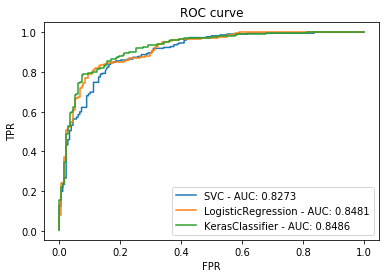

In [24]:
create_roc(pipeline_list, test_x, test_y)

### Discussion

From the experiments performed the following conclusions were drawn:
- removing **stop-words** decreased performance by a score of aproximately $1\%$
- Performance improved linearly increasing the value of **max_features** of the TF-IDF vectorizer
- higher values of max_features allowed to use more **singular components** in the SVD, which improved performance
- **stemming** and **lemmatizing** respectivel decreased the performance by $1\%$ and $2\%$. This is problem dependant because in other occasions stemming and lemmatizing helped.
- the optimal ngram_range of the TF-IDF vectorized depended on the classifier considered. SVM and ANN worked better with range (1,3), whereas LR preferred (1,1)